# QamomileにおけるPennyLaneTranspilerの使用  
このチュートリアルでは、QamomileにおけるPennyLaneTranspilerの使用方法を示し、効果的に活用するための主要な例を提供します。

## ハミルトニアンのPennyLaneへの変換
まず、テスト用のHamiltonianを定義し、それをPennyLaneに対応する形式に変換するためにTranspilerを使用します。このステップでは、私たちのライブラリで定義されたHamiltonianがPennyLaneに認識されるオペレーターへとシームレスに変換される様子を示します。

In [ ]:
import jijmodeling as jm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pennylane as qml
from pennylane import numpy as p_np

import qamomile
from qamomile.core.operator import Hamiltonian, Pauli, X, Y, Z
from qamomile.core.circuit import QuantumCircuit as QamomileCircuit
from qamomile.core.circuit import (
    QuantumCircuit,
    SingleQubitGate,
    TwoQubitGate,
    ParametricSingleQubitGate,
    ParametricTwoQubitGate,
    SingleQubitGateType,
    TwoQubitGateType,
    ParametricSingleQubitGateType,
    ParametricTwoQubitGateType,
    Parameter
)
from qamomile.core.circuit.drawer import plot_quantum_circuit
from qamomile.pennylane.transpiler import PennylaneTranspiler

このコードスニペットでは、X・Y・Z の各パウリ演算子を用いたカスタム定義のハミルトニアンから始め、`PennylaneTranspiler`を使ってそれをPennyLaneデバイスに直接適した形式へ変換します。`ops_first_term`を確認し、`pennylane_hamiltonian`を出力することで、変換が正しく行われているかを検証できます。

In [2]:
hamiltonian = Hamiltonian()
hamiltonian += X(0)*Z(1)
hamiltonian += Y(0)*Y(1)*Z(2)*X(3)*X(4)

transpiler = PennylaneTranspiler()
pennylane_hamiltonian = transpiler.transpile_hamiltonian(hamiltonian)

ops_first_term = pennylane_hamiltonian.terms()[1][0]
print(pennylane_hamiltonian)

1.0 * (X(0) @ Z(1) @ I(2) @ I(3) @ I(4)) + 1.0 * (Y(0) @ Y(1) @ Z(2) @ X(3) @ X(4))


## パラメータ化された量子回路の構築

次に、`QamomileCircuit`を使用してパラメータ化された量子回路を構築します。ここでは、単一量子ビットの回転ゲート（rx、ry、rz）や制御付きのバリエーション（crx、crz、cry）、さらに 2 量子ビットのエンタングルゲート（rxx、ryy、rzz）を含めます。パラメータ（theta、beta、gamma）は、柔軟な変分調整を可能にします。

In [3]:
qc = QamomileCircuit(3)
theta = Parameter("theta")
beta = Parameter("beta")
gamma = Parameter("gamma")

qc.rx(theta, 0)
qc.ry(beta, 1)
qc.rz(gamma, 2)
qc.crx(gamma, 0 ,1)
qc.crz(theta, 1 ,2)
qc.cry(beta, 2 ,0)
qc.rxx(gamma, 0 ,1)
qc.ryy(theta, 1 ,2)
qc.rzz(beta, 2 ,0)

transpiler = PennylaneTranspiler()
QNode = transpiler.transpile_circuit(qc)

## MaxCut問題の定式化と量子形式への変換

このセクションでは、古典的な最適化問題であるMaxCutを、イジング形式のハミルトニアンにエンコードする方法を示します。その後、QAOAスタイルのアンザッツ回路を構築し、それを実行・最適化することで、MaxCutインスタンスの解を求めます。

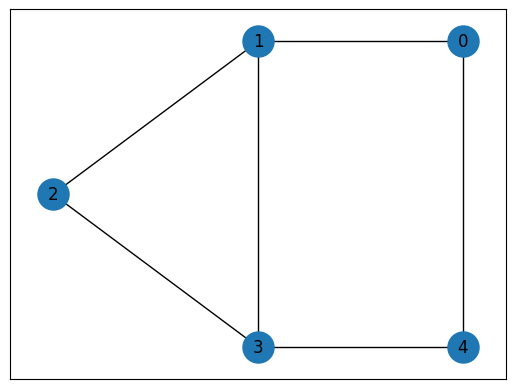

In [4]:
def maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem

def maxcut_instance():
    # MaxCutインスタンスのために簡単なグラフを構築します。
    G = nx.Graph()
    G.add_nodes_from([0, 1, 2, 3, 4])
    G.add_edges_from([(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)])
    E = [list(edge) for edge in G.edges]
    instance_data = {"V": G.number_of_nodes(), "E": E}
    pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
    nx.draw_networkx(G, pos, node_size=500)
    return instance_data

problem = maxcut_problem()
instance_data = maxcut_instance()
interpreter = jm.Interpreter(instance_data)
compiled_instance = interpreter.eval_problem(problem)

# コンパイルした問題をQAOA形式へ変換する
qaoa_converter = qamomile.core.qaoa.QAOAConverter(compiled_instance)
qaoa_converter.ising_encode()

p = 5
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

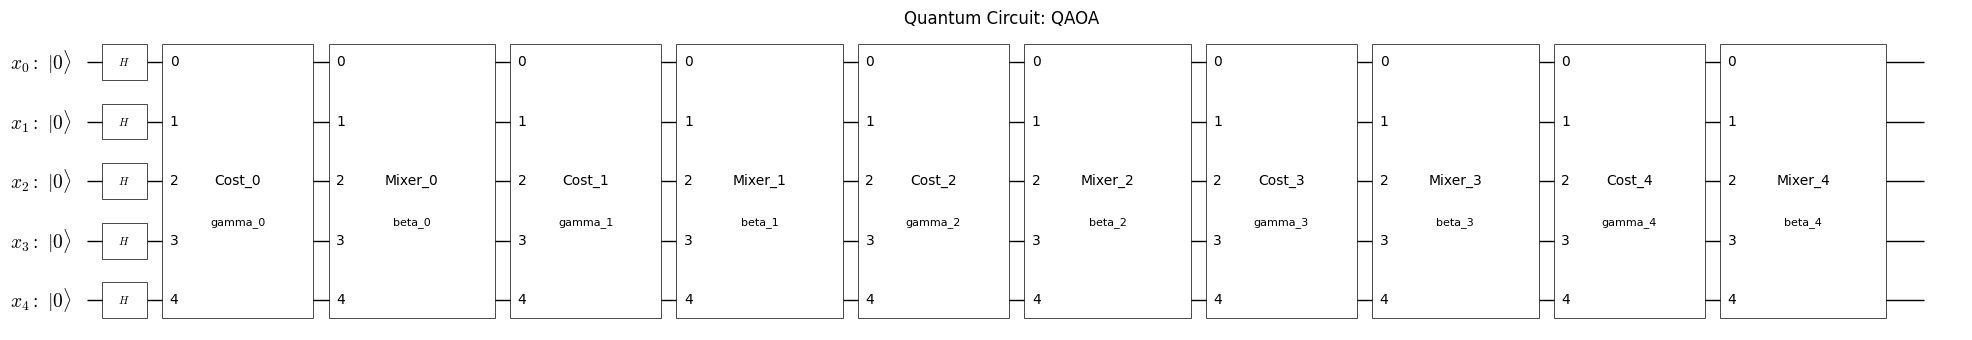

In [5]:
plot_quantum_circuit(qaoa_circuit)

私たちは現在、MaxCut問題をQAOAのようなアルゴリズムに適したコストハミルトニアンに変換しました。パラメータ`p`は問題およびミキサーハミルトニアンの層数を決定します。各層のパラメータは変分可能であり、期待値を最小化するように調整され、理想的にはMaxCutインスタンスの良い解を導くことが期待されます。

## PennyLaneでのQAOA回路のトランスパイルと実行

QAOA回路とハミルトニアンが定義されたら、再びトランスパイラを使用し、今回はQAOA回路とコストハミルトニアンをPennyLane形式に変換します。

In [6]:
transpiler = PennylaneTranspiler()
circ_func = transpiler.transpile_circuit(qaoa_circuit)
qml_hamiltonian = transpiler.transpile_hamiltonian(qaoa_hamiltonian)

dev = qml.device("default.qubit", wires=qaoa_circuit.num_qubits)

@qml.qnode(dev)
def circuit(params, return_samples=False):
    circ_func(params)
    if return_samples:
        return qml.sample()
    return qml.expval(qml_hamiltonian)

parameters = p_np.array([np.pi/4, np.pi/4]*p, requires_grad=True)
print("Initial Expectation Value:", circuit(parameters))
cost_history = []
cost_history.append(circuit(parameters))

Initial Expectation Value: 0.6975904406316913


ここで、`circ_func`はQAOAアンザッツから生成されたPennyLane回路関数です。`circuit(p)`を評価することで、与えられたパラメータ`p`に対するコストハミルトニアンの期待値が得られます。

## パラメータの最適化

最後に、PennyLaneの最適化手法を用いてパラメータを更新し、より良い結果（例えば、MaxCut目的関数のコストが低いもの）をもたらすような値を探索します。

In [7]:
max_iterations = 1000
optimizer = qml.GradientDescentOptimizer(stepsize=5e-2)
for i in range(max_iterations):
    parameters, loss= optimizer.step_and_cost(circuit, parameters)
    cost_history.append(loss)
    
print("Optimal Parameters")
print(parameters)

Optimal Parameters
[ 0.35271931  1.02327598  0.74961704  1.12583207  0.91321306 -0.38421535
  1.08607428  1.27879381  1.12025286  1.42425253]


## 結果の可視化

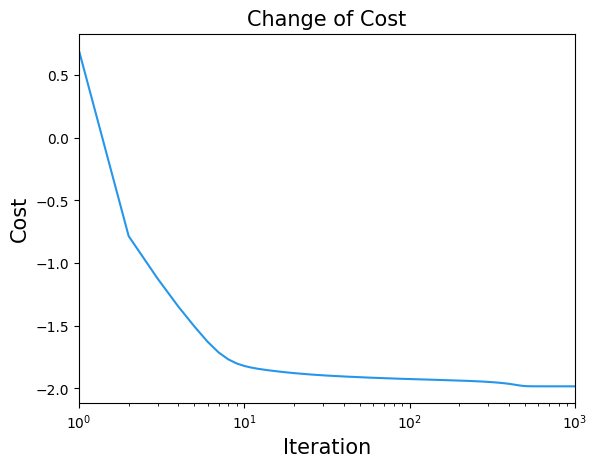

In [8]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, max_iterations)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

最適化されたパラメータが得られたら、PennyLaneのQNodeを使用してパラメータ化された量子回路からサンプルを取得し、回路の測定結果（カウント）を取得します。

In [9]:
dev_counts = qml.device("default.qubit", wires=qaoa_circuit.num_qubits, shots=1000)
@qml.qnode(dev_counts)
def circuit_counts(params):
    circ_func(params)
    return qml.counts()
result = circuit_counts(parameters)

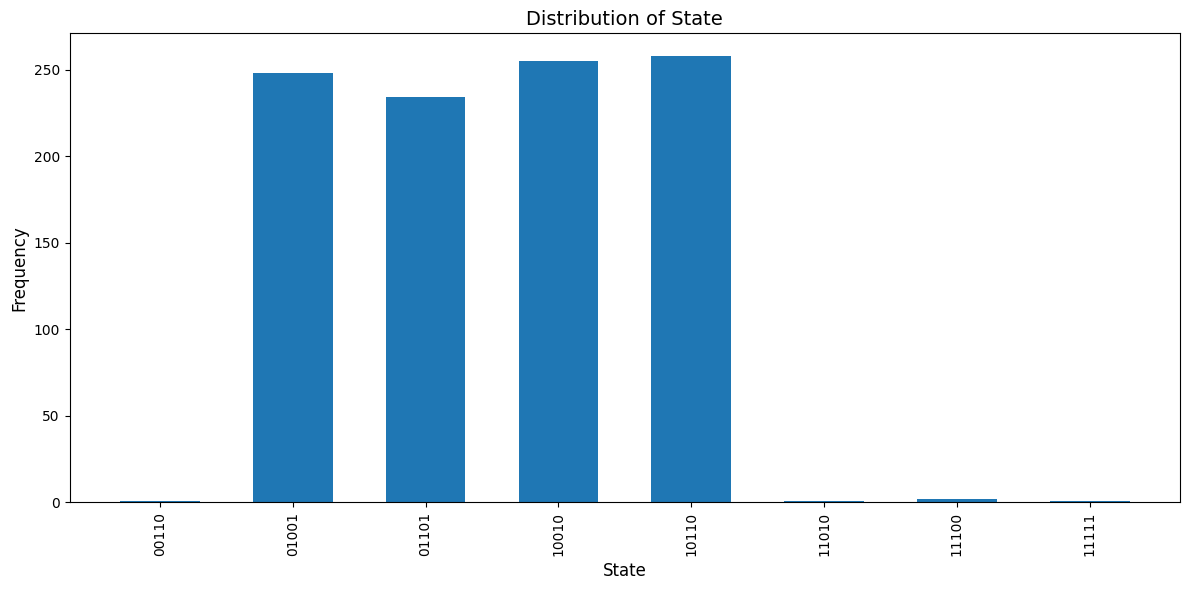

In [10]:
# プロットのためのデータを準備する
keys = list(result.keys())
values = list(result.values())

# プロットする
plt.figure(figsize=(12, 6))
plt.bar(keys, values, width=0.6)
plt.xlabel("State", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of State", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

## 結果の評価  
前に得られた `qaoa_counts`から、`qaoa_converter.decode`を使ってサンプルセットに変換することができます。このサンプルセットから実行可能な解のみを選択し、目的関数の値の分布を調べます。

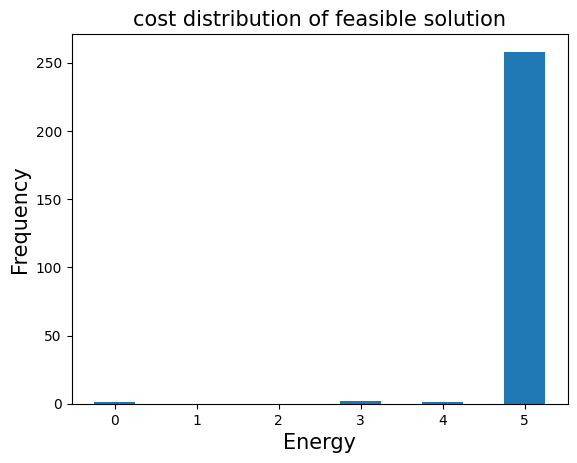

In [11]:
sampleset = qaoa_converter.decode(transpiler, result) 
feasible_ids = sampleset.summary.query("feasible == True").index
energies = []
frequencies = []
for entry in sampleset.raw.objectives.entries:
    energies.append(entry.value)
    feasible_count = len([_id for _id in entry.ids if _id in feasible_ids])
    frequencies.append(feasible_count)

plt.bar(energies, frequencies, width=0.5)
plt.title("cost distribution of feasible solution", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()